<a href="https://colab.research.google.com/github/mike-keating-iv/polymer-classification/blob/main/polymers_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polymers Classifier

EM 538
Instructor:  
Student: Mike Keating


## Introduction

### Problem Definition

Polymeric materials are ubiquitous in our world and nearly every industry. Materials are selected based on physical, mechanical, thermal, and economic characteristics for any given application. Polymers as a class of materials have an extremely wide range of potential properties, from relatively soft low-density polyethylene (LDPE) to extremely strong and rigid engineering polymers such as Kevlar (Polyaramid) or PEEK.

In addition to broad classifications such as thermoplastic, elastomer, and thermosets, many polymers can be classified by their polymer subclass or specific chemical composition of the repeat unit. This is often how we think of plastics, with symbols like PP (polypropylene), PET (polyester terephthalate), and ABS (acrylonitrile-butadiene-styrene).

The goal of this project is to classify polymer materials into their respective polymer subclass using point mechanical data as features. Examples of these mechanical properties include tensile strength at break, izod impact, flexural modulus, and elongation at break. Other physical properties may also be used as features – such as density, melt flow rate, etc.

### Significance

A large component of medical device research and development is centered around materials selection and lifecycle management. Many companies run their own mechanical testing labs or outsource data collection to vendors to help make their decisions. I happen to work in such an internal testing lab and manage a materials database to store our large and growing amounts of materials data. One way to organize records in the schema of this database is by material class and subsequently subclass (whether they are polymers or metals, etc).

Now, often at least the polymer subclass (PP, etc) is known by the supplier, but often in R&D this information can get miscommunicated or is not available (for development grades). Automating this subclass assignment would accelerate data upload while keeping the database schema organized.

### Objectives

- Achieve a more efficient import process for materials of unknown subclass by predicting this subclass based on physical and mechanical properties.
- The goal is to achieve a class assignment system that is accurate and reliable for use in R&D and database management.


## EDA, Cleaning, Preprocessing

### Data Source

Data was collected from the Plastics and Elastomers section of [UL Prospector](https://www.ulprospector.com/plastics/en), which is a database containing technical data for over 100,000 materials.

Data was queried by polymer symbol (PP, PMMA, etc) and saved to separate csv files. Due to the nature of the search, there are likely blends and special materials included in each dataset, and we will want to pair down to a reasonable number of polymer classes


In [ ]:
# Clone github into colab
# Only uncomment and run this cell if you are running from google colab
!git clone https://github.com/mike-keating-iv/polymer-classification

fatal: destination path 'polymer-classification' already exists and is not an empty directory.


In [ ]:
import os
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
# Combine all of the .csv files into one df
df = pd.DataFrame()
# Handle the case where the data is in a subdirectory, i.e. running it from a cloned repo
try:
    for file in os.listdir("polymer-classification/data"):
        if file.endswith(".csv"):
            df_tmp = pd.read_csv(os.path.join("polymer-classification/data", file))
            df = pd.concat([df, df_tmp], ignore_index=True)
except FileNotFoundError:
    for file in os.listdir("data"):
        if file.endswith(".csv"):
            df_tmp = pd.read_csv(os.path.join("data", file))
            df = pd.concat([df, df_tmp], ignore_index=True)

# Discard completely empty columns
df = df.dropna(axis=1, how="all")
# Drop polymer code column
df = df.drop("Polymer_Code", axis=1, errors="ignore")
# Clean up column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_").str.replace("(", "").str.replace(")", "")
# Convert all column names to lowercase
df.columns = df.columns.str.lower()
# Remove degree symbol from column names
df.columns = df.columns.str.replace("°", "").str.replace("^", "").str.replace("/", "")
# Get rid of units in column names
units_to_remove = ["_gcm3", "_mpa", "_c", "_%_strain", "_23c_kjm2"]
for unit in units_to_remove:
    df.columns = df.columns.str.replace(unit, "")
df.columns = df.columns.str.replace("generic_polymer_symbol", "polymer_class")


In [ ]:
# Drop hardness columns since the scales vary and there is not a direct conversion
df = df.drop(["hardness_shore_d", "hardness_rockwell_r"], axis=1, errors="ignore")

# drop product_name, grade, generic_polymer_type
df = df.drop(["product_name", "grade", "generic_polymer_type"], axis=1, errors="ignore")
df.describe()

,density,tensile_strength_at_yield,melting_temperature,flexural_modulus,flexural_strength,tensile_modulus,tensile_strength_at_break,tensile_elongation_at_yield,tensile_elongation_at_break,izod_notched_impact
count,90013.000000,41474.000000,21905.000000,6.462500e+04,38131.000000,40056.000000,32333.000000,25546.000000,57706.000000,50658.000000
mean,1.219564,47.601638,208.005775,4.282031e+03,130.349497,5509.193415,78.071045,14.035342,121.637527,35.992922
std,4.424561,57.464644,52.036752,3.409535e+04,149.785827,5401.206573,107.106461,57.449070,1718.660233,133.546056
min,0.000920,0.082700,0.000000,9.650000e-01,0.000000,0.000000,0.000000,0.200000,0.000000,0.016000
25%,1.020000,26.000000,166.000000,1.590000e+03,68.300000,2160.000000,23.500000,3.900000,3.400000,5.196078
50%,1.180000,36.000000,220.000000,2.410000e+03,100.000000,3200.000000,60.000000,6.000000,16.000000,9.411765
75%,1.350000,60.000000,260.000000,5.240000e+03,180.000000,7700.000000,117.000000,10.000000,120.000000,20.000000
max,950.000000,9510.000000,387.000000,8.600000e+06,20700.000000,138000.000000,14000.000000,3700.000000,300000.000000,3921.568627


In [ ]:
# Get an idea of the types of groups
df.groupby("polymer_class").size().sort_values(ascending=False)

,0
polymer_class,
"PP, Unspecified",10070
Nylon 6,9530
PP Homopolymer,9416
Nylon 66,9011
PP Copolymer,5960
...,...
PSU+ABS,1
PUR-PC,1
PTFE+PI,1


In [ ]:
# Discard polymer symbols that are blends, films, copolymers, alloys
# A blend has a "+" in the symbol
df = df[~df["polymer_class"].str.contains("\\+", na=False)]
# A film has "film" in the symbol
df = df[~df["polymer_class"].str.contains("Film", na=False)]
# An alloy has "alloy" in the symbol
df = df[~df["polymer_class"].str.contains("Alloy", na=False)]
# A copolymer has "copolymer" in the symbol
df = df[~df["polymer_class"].str.contains("Copolymer", na=False)]
# We are only trying to classify rigid polymers
df = df[~df["polymer_class"].str.contains("Flexible", na=False)]

# Discard any classes that have less than 250 samples
df_counts = df.groupby("polymer_class").size()
df = df[df["polymer_class"].isin(df_counts[df_counts >= 250].index)]
df.groupby("polymer_class").size().sort_values(ascending=False)

,0
polymer_class,
"PP, Unspecified",10070
Nylon 6,9530
PP Homopolymer,9416
Nylon 66,9011
PC,5457
"PVC, Unspecified",4949
ABS,3153
HDPE,2673
PPS,2212


For the purpose of this assigment, let's scale down our dataset to only the top handful of groups. We may downselect this further.



In [ ]:
# Compile and assign some polymer symbols to groups
df["polymer_class"] = df["polymer_class"].replace(
    {
        "Nylon 6": "Nylon",
        "Nylon 66": "Nylon",
        "PP Homopolymer": "PP",
        "PC": "PC",
        "ABS": "ABS",
        "HDPE": "HDPE",
        "PPS": "PPS",
        "LDPE": "LDPE",
        "PEEK": "PEEK",
        "PVC, Rigid": "PVC",
        "Acrylic (PMMA)": "PMMA",
    }
)
print(df.groupby("polymer_class").size().sort_values(ascending=False))
# Discard anything not in the above groups
df = df[df["polymer_class"].isin(["Nylon", "Polypropylene", "PC", "ABS", "HDPE", "PPS", "LDPE", "PEEK", "PP", "PVC", "PMMA"])]

df.groupby("polymer_class").size().sort_values(ascending=False)

polymer_class
Nylon                       18541
PP, Unspecified             10070
PP                           9416
PC                           5457
PVC, Unspecified             4949
ABS                          3153
HDPE                         2673
PPS                          2212
LLDPE                        1886
LDPE                         1797
PVC                           986
PEEK                          847
EVA                           773
PET                           648
Nylon 12                      646
PMMA                          622
PEI                           563
Nylon, Unspecified            506
Nylon 66/6                    468
PTFE                          400
Nylon 612                     374
ASA                           354
Acetal (POM) Homopolymer      351
Nylon 610                     256
dtype: int64


,0
polymer_class,
Nylon,18541
PP,9416
PC,5457
ABS,3153
HDPE,2673
PPS,2212
LDPE,1797
PVC,986
PEEK,847


In [ ]:
# Get an idea of missing values per group
df_missing = df.isnull().sum().sort_values(ascending=False)
df_missing = df_missing[df_missing > 0]
df_missing = df_missing.to_frame(name="Missing Values")
df_missing["Percentage"] = df_missing["Missing Values"] / len(df) * 100
df_missing = df_missing.sort_values(by="Percentage", ascending=False)
print(df_missing)
# Discard columns that have more than
threshold_col = len(df) * 0.5
df = df.dropna(thresh=threshold_col, axis=1)

# Discard rows that have more than 70% missing values (increased from 55%)
threshold_row = len(df.columns) * 0.5
df = df.dropna(thresh=threshold_row, axis=0)
df.head()

                             Missing Values  Percentage
melting_temperature                   34187   74.800893
tensile_elongation_at_yield           32674   71.490460
tensile_strength_at_break             28266   61.845790
tensile_strength_at_yield             25931   56.736828
flexural_strength                     22564   49.369858
tensile_modulus                       22121   48.400578
izod_notched_impact                   18335   40.116839
tensile_elongation_at_break           15257   33.382198
flexural_modulus                      11700   25.599510
density                                2091    4.575092


,polymer_class,density,flexural_modulus,flexural_strength,tensile_modulus,tensile_elongation_at_break,izod_notched_impact
34,PP,1.12,1900.0,44.0,NaN,100.0,2.647059
36,PP,1.13,5000.0,112.0,NaN,3.0,9.313725
41,PP,0.95,2000.0,50.0,NaN,20.0,2.450980
42,PP,1.02,2300.0,45.0,NaN,20.0,2.450980
47,PP,0.90,1300.0,NaN,NaN,110.0,3.000000


In [ ]:
# Get a subset of each group to balance the dataset
df_balanced = pd.DataFrame()
for group in df["polymer_class"].unique():
    df_group = df[df["polymer_class"] == group]
    print(f"Creating subset of class: {group}")
    print(f"Number of rows: {len(df_group)}")
    # Drop rows with any missing values - keep this as models require complete data

    df_group = df_group.dropna()
    print(f"Number of rows after dropping missing values: {len(df_group)}")
    # Get a random sample of up to 1000 rows (increased from 500)
    sample_size = min(1000, len(df_group))
    if sample_size > 0:
        df_sample = df_group.sample(n=sample_size, random_state=42)
        df_balanced = pd.concat([df_balanced, df_sample], ignore_index=True)
# Discard any groups with less than 50 samples (decreased from 100)
df_counts = df_balanced.groupby("polymer_class").size()
df_balanced = df_balanced[df_balanced["polymer_class"].isin(df_counts[df_counts >= 50].index)]

df_balanced.polymer_class.value_counts()

Creating subset of class: PP
Number of rows: 7322
Number of rows after dropping missing values: 594
Creating subset of class: PPS
Number of rows: 2038
Number of rows after dropping missing values: 342
Creating subset of class: PEEK
Number of rows: 800
Number of rows after dropping missing values: 209
Creating subset of class: PC
Number of rows: 5225
Number of rows after dropping missing values: 920
Creating subset of class: LDPE
Number of rows: 352
Number of rows after dropping missing values: 5
Creating subset of class: PMMA
Number of rows: 551
Number of rows after dropping missing values: 73
Creating subset of class: ABS
Number of rows: 2965
Number of rows after dropping missing values: 348
Creating subset of class: PVC
Number of rows: 762
Number of rows after dropping missing values: 79
Creating subset of class: HDPE
Number of rows: 1769
Number of rows after dropping missing values: 36
Creating subset of class: Nylon
Number of rows: 17367
Number of rows after dropping missing values

,count
polymer_class,
Nylon,1000
PC,920
PP,594
ABS,348
PPS,342
PEEK,209
PVC,79
PMMA,73


In [ ]:
# View our final groups and columns
df_balanced.groupby("polymer_class").size().sort_values(ascending=False)

# Create a df of the columns
df_columns = pd.DataFrame(df_balanced.columns, columns=["Column"])
df_columns["Data Type"] = df_balanced.dtypes.values
display(df_columns)

# Add a check for missing values in the final df_balanced DataFrame
print("\nMissing values in the final df_balanced DataFrame:")
print(df_balanced.isnull().sum())

,Column,Data Type
0,polymer_class,object
1,density,float64
2,flexural_modulus,float64
3,flexural_strength,float64
4,tensile_modulus,float64
5,tensile_elongation_at_break,float64
6,izod_notched_impact,float64



Missing values in the final df_balanced DataFrame:
polymer_class                  0
density                        0
flexural_modulus               0
flexural_strength              0
tensile_modulus                0
tensile_elongation_at_break    0
izod_notched_impact            0
dtype: int64


## Final Feature Descriptions

- **polymer_class**: The subclass of the polymer material (e.g., PP, PET, ABS).
- **density**: The density of the polymer material, typically measured in g/cm³.
- **tensile_strength_at_break**: The tensile strength of the material at the point of failure, measured in MPa.
- **izod_impact**: The impact resistance of the material, measured using the Izod impact test.
- **flexural_modulus**: The stiffness of the material under bending, measured in MPa.
- **elongation_at_break**: The percentage elongation of the material at the point of failure.
- **melt_flow_rate**: The rate of flow of the polymer material when melted, typically measured in g/10 min.

These variables are used as features to classify the polymer materials into their respective subclasses.


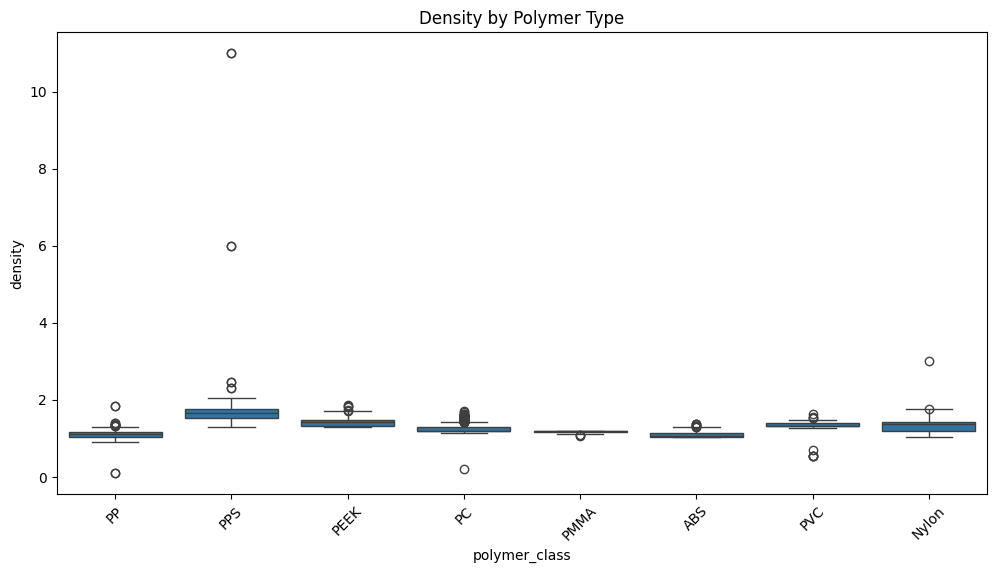

In [ ]:
# EDA Boxplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x="polymer_class", y="density", data=df_balanced)
plt.title("Density by Polymer Type")
plt.xticks(rotation=45)
plt.show()


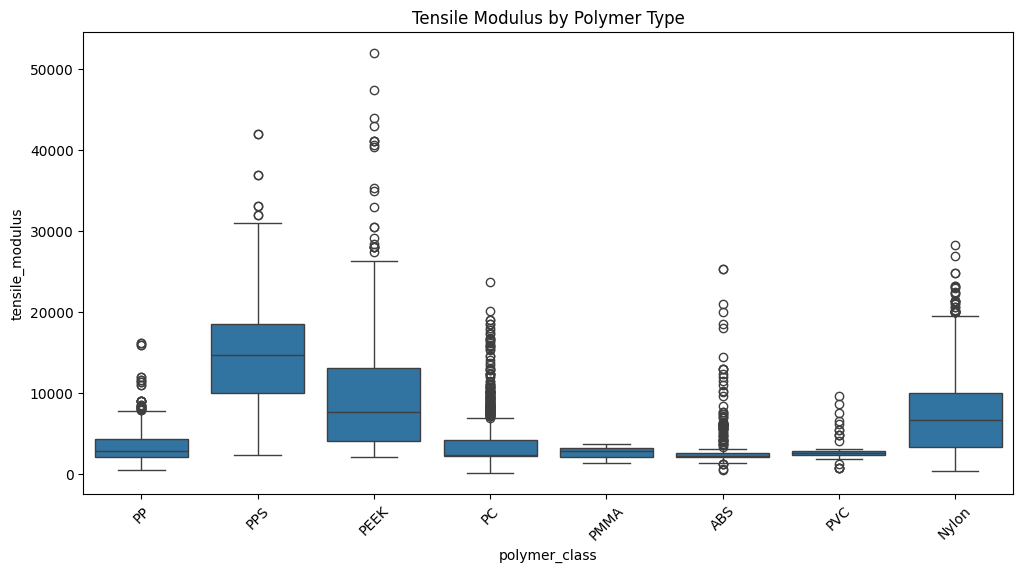

In [ ]:
# Repeat for tensile modulus
plt.figure(figsize=(12, 6))
sns.boxplot(x="polymer_class", y="tensile_modulus", data=df_balanced)
plt.title("Tensile Modulus by Polymer Type")
plt.xticks(rotation=45)
plt.show()


We have some extreme outliers in the dataset for each group.

This is possibly due to an error with the datasource (unit issues, etc). For instance, a density above 10 g/cc is pretty unrealistic and certainly not typical of a polymer.

Let's handles this by removing any outliers not in the IQR by group and by column.

This may obscure some of the natural variability in our data (polymers can vary widely), but at least the core of each group will be preserved.


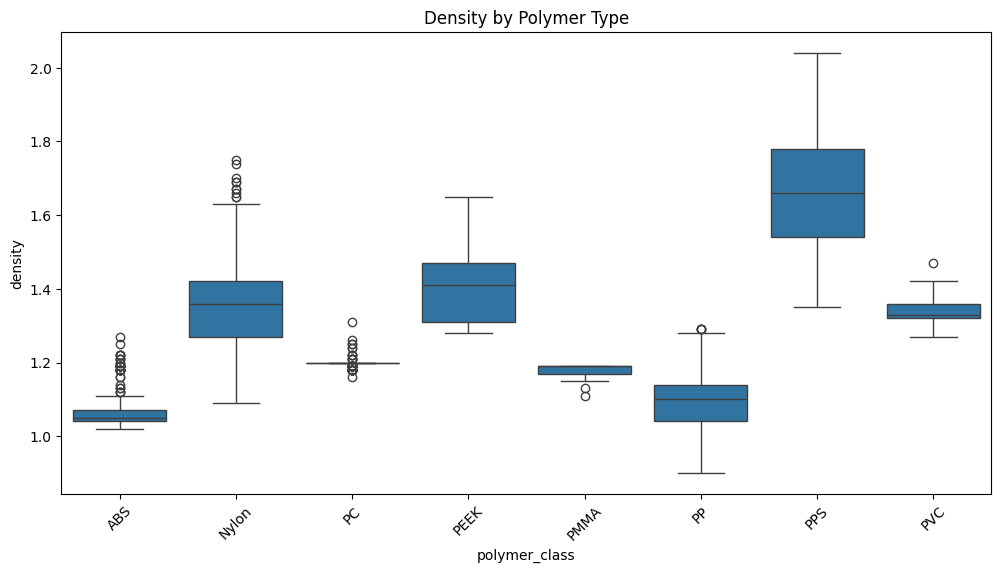

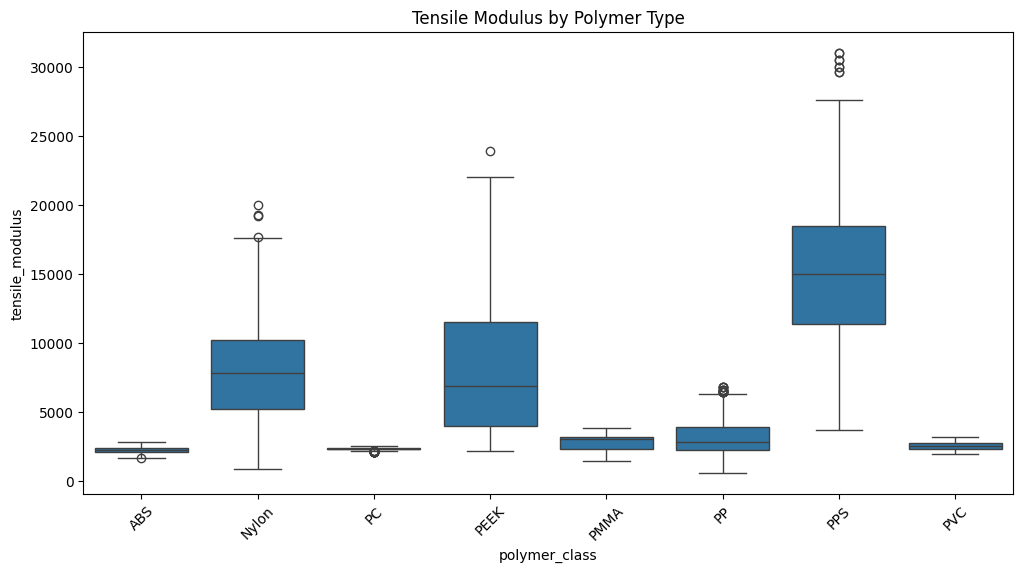

In [ ]:
# Handle outliers
# Discard outliers in density


def remove_iqr_outliers(group):
    num_cols = group.select_dtypes(include="number").columns
    for col in num_cols:
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        # inter quartile range
        IQR = q3 - q1
        lower = q1 - 1.5 * IQR
        upper = q3 + 1.5 * IQR
        group = group[(group[col] >= lower) & (group[col] <= upper)]
    return group


df_balanced = df_balanced.groupby("polymer_class", group_keys=False).apply(remove_iqr_outliers)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x="polymer_class", y="density", data=df_balanced)
plt.title("Density by Polymer Type")
plt.xticks(rotation=45)
plt.show()

# Repeat for tensile modulus
plt.figure(figsize=(12, 6))
sns.boxplot(x="polymer_class", y="tensile_modulus", data=df_balanced)
plt.title("Tensile Modulus by Polymer Type")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_balanced.groupby("polymer_class").size().sort_values(ascending=False)

,0
polymer_class,
Nylon,774
PP,478
PC,409
PPS,284
ABS,238
PEEK,162
PMMA,60
PVC,59


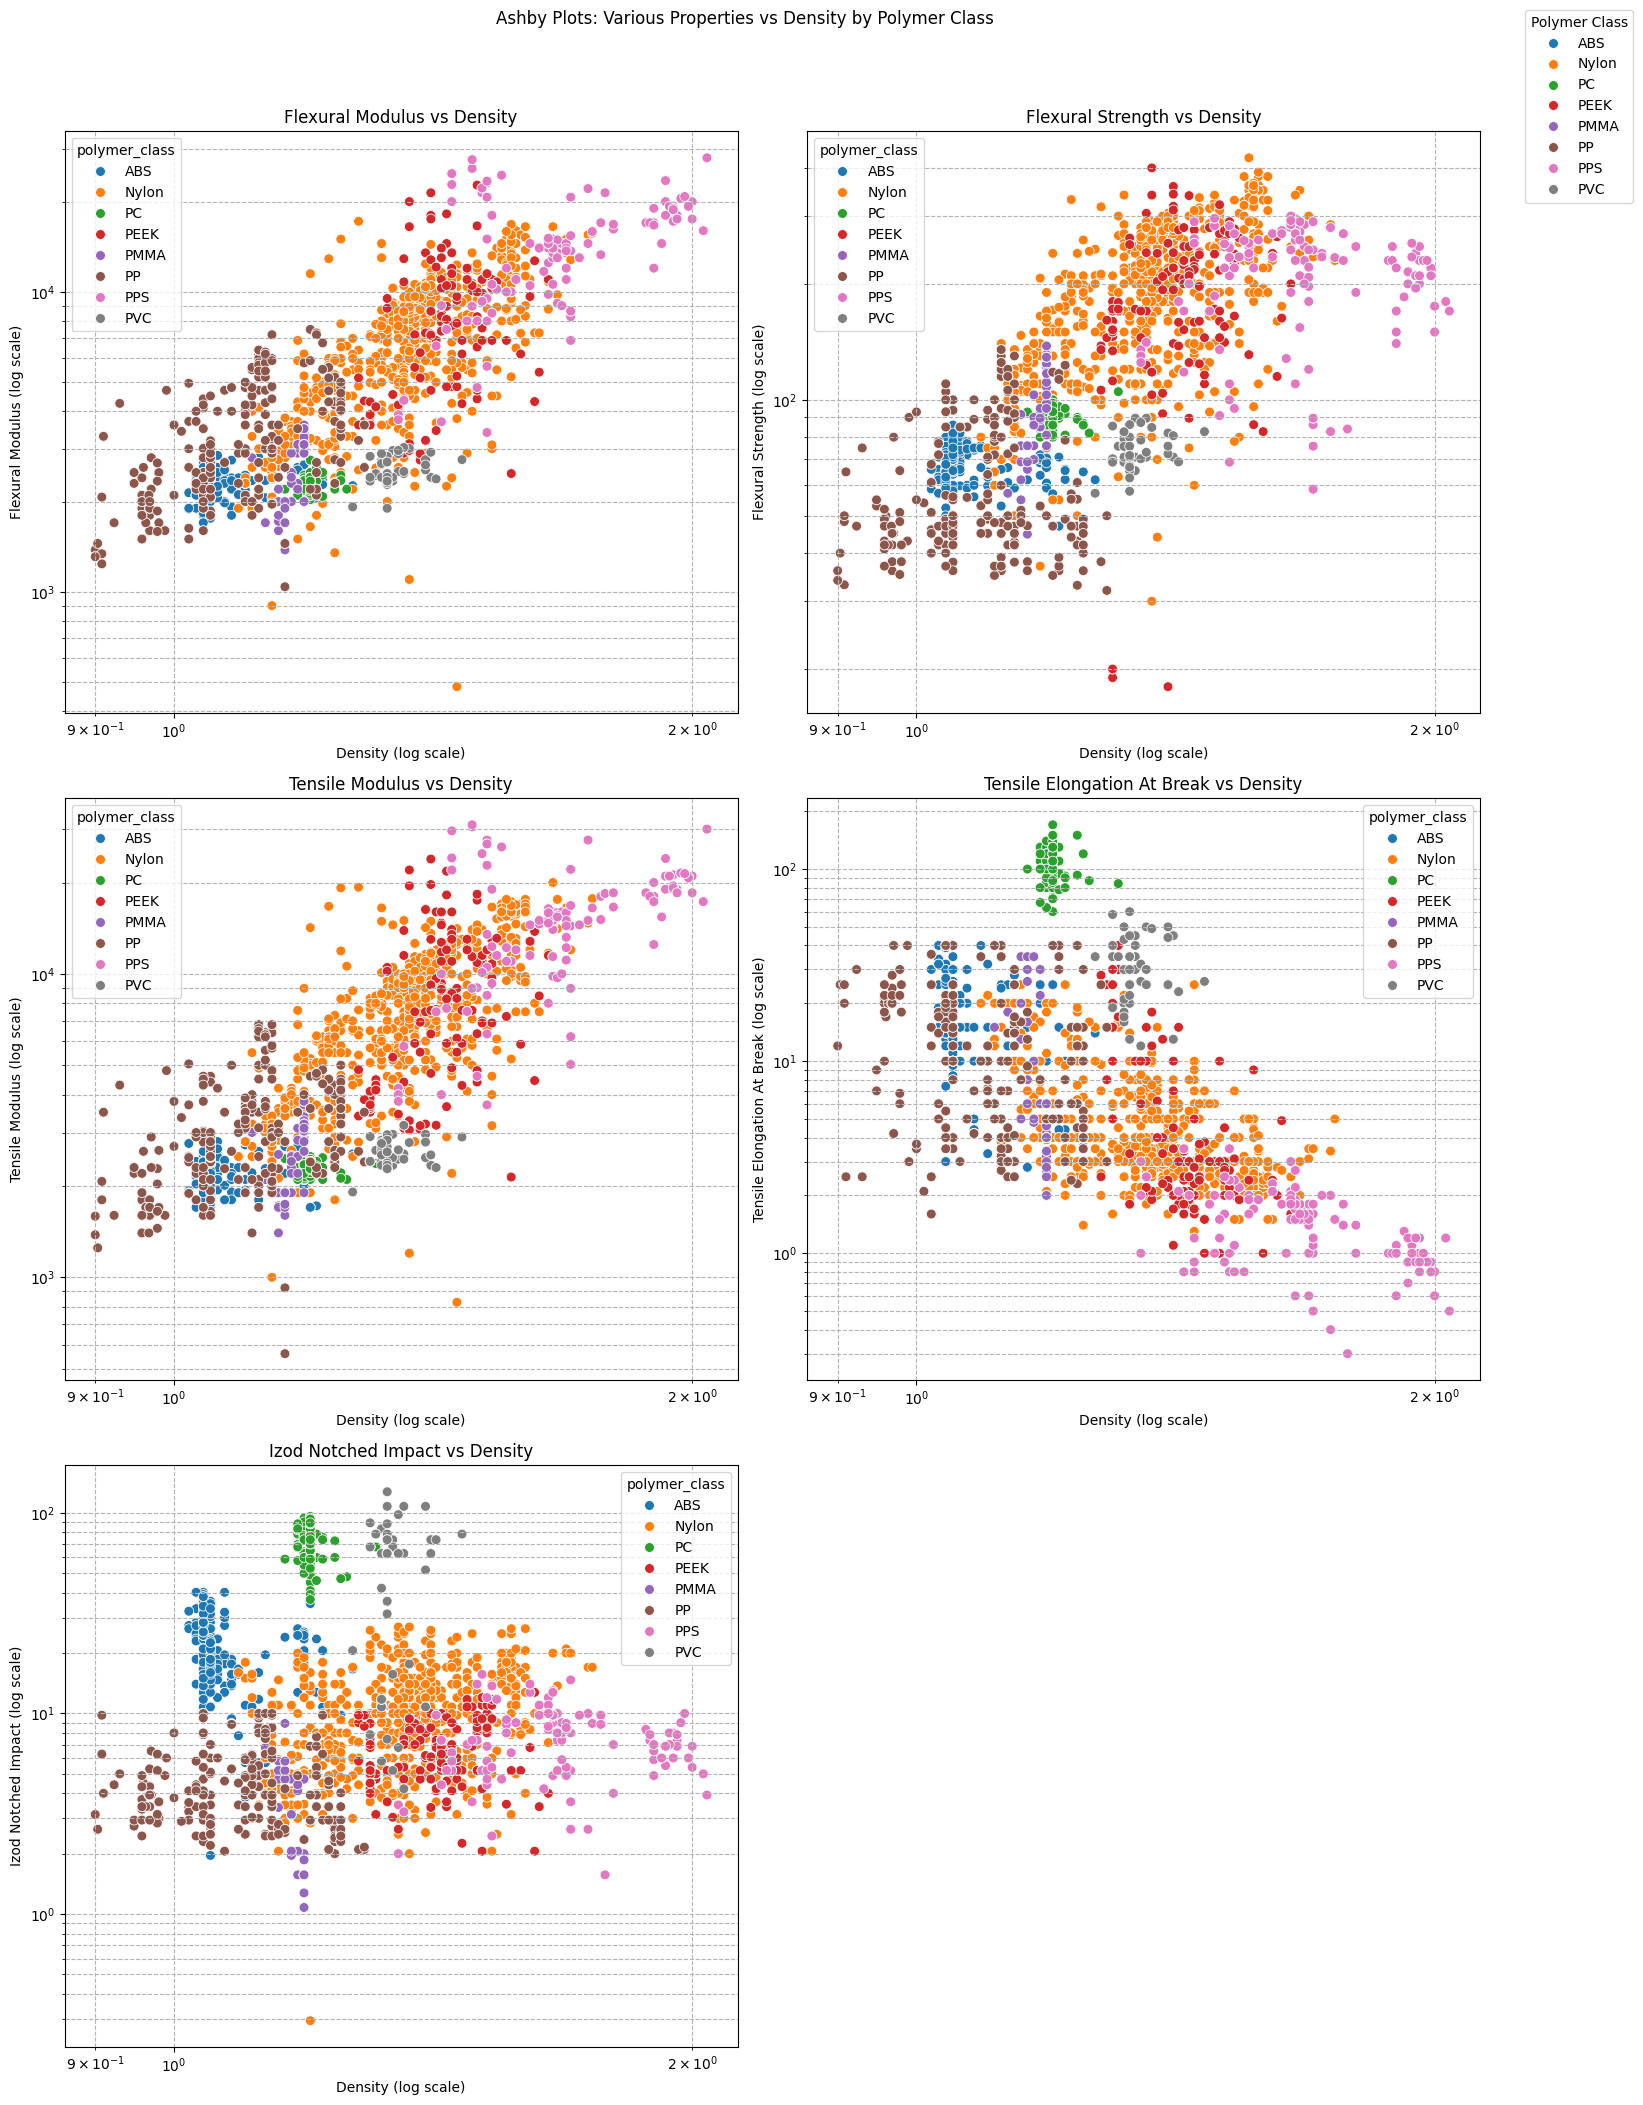

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Make a copy for plotting
df_plot = df_balanced.copy()

numerical_features = df_plot.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Remove 'density' and 'polymer_class' from the list of features to plot against density
features_to_plot = [feature for feature in numerical_features if feature != 'density' and feature != 'polymer_class']

# Determine the number of rows and columns for the subplots
n_features = len(features_to_plot)
n_cols = 2  # You can adjust the number of columns
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 7), squeeze=False)
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, feature in enumerate(features_to_plot):
    sns.scatterplot(x="density", y=feature, hue="polymer_class", data=df_plot, palette='tab10', s=50, ax=axes[i])
    axes[i].set_xscale('log') # Set x-axis to log scale
    axes[i].set_yscale('log') # Set y-axis to log scale
    axes[i].set_title(f"{feature.replace('_', ' ').title()} vs Density")
    axes[i].set_xlabel("Density (log scale)")
    axes[i].set_ylabel(f"{feature.replace('_', ' ').title()} (log scale)")
    axes[i].grid(True, which="both", ls="--", c='0.7')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Polymer Class", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for the legend
plt.suptitle("Ashby Plots: Various Properties vs Density by Polymer Class", y=1.0) # Add a main title
plt.show()

### Preprocessing for ML


In [ ]:
# Scale and encode the data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Scale the numerical features
scaler = StandardScaler()
numerical_features = df_balanced.select_dtypes(include=["float64", "int64"]).columns.tolist()
df_balanced[numerical_features] = scaler.fit_transform(df_balanced[numerical_features])

# Encode the categorical features
label_encoder = LabelEncoder()
df_balanced["polymer_class"] = label_encoder.fit_transform(df_balanced["polymer_class"])

# Split the data into training and test sets
X = df_balanced.drop("polymer_class", axis=1)
y = df_balanced["polymer_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Modeling


### Logistic Regression


Best parameters for Logistic Regression: {'logisticregression__C': 10, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

         ABS       0.94      0.96      0.95        47
       Nylon       0.83      0.89      0.86       155
          PC       1.00      1.00      1.00        82
        PEEK       0.59      0.41      0.48        32
        PMMA       0.85      0.92      0.88        12
          PP       0.93      0.97      0.95        96
         PPS       0.89      0.84      0.86        57
         PVC       1.00      0.58      0.74        12

    accuracy                           0.89       493
   macro avg       0.88      0.82      0.84       493
weighted avg       0.88      0.89      0.88       493

Training time for Logistic Regression (Grid Search): 17.87 seconds


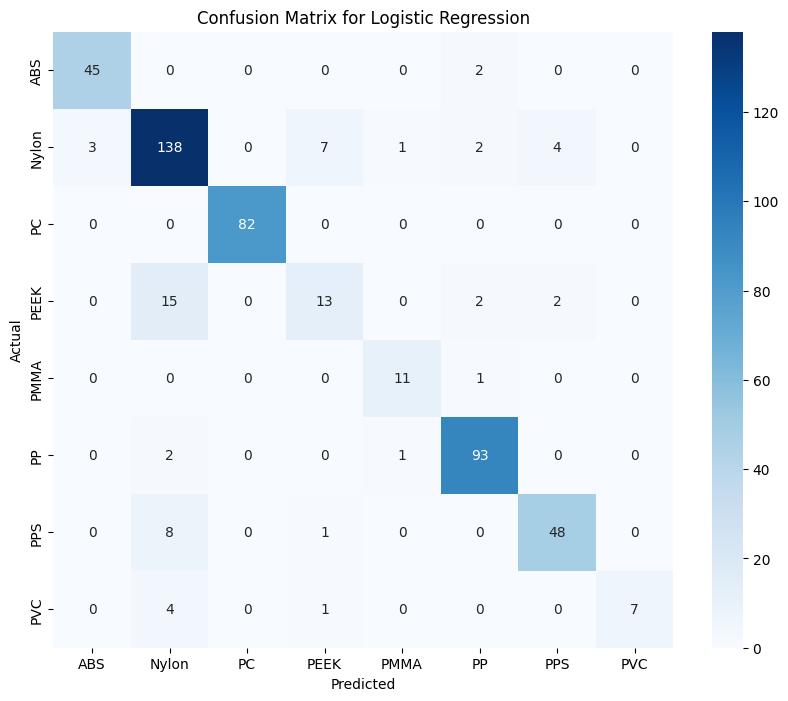

In [110]:
# Multi-class logistic regression
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import time

pipe_logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
# Record training time
start_time_logreg = time.time()
grid_search_logreg.fit(X_train, y_train)
end_time_logreg = time.time()
train_time_logreg = end_time_logreg - start_time_logreg

param_grid_logreg = [
    {
        "logisticregression__solver": ["lbfgs"],
        "logisticregression__C": [0.01, 0.1, 1, 10],
        "logisticregression__penalty": ["l2"],
    },
    {
        "logisticregression__solver": ["liblinear"],
        "logisticregression__C": [0.01, 0.1, 1, 10],
        "logisticregression__penalty": ["l2"],
    },
    {
        "logisticregression__solver": ["saga"],
        "logisticregression__C": [0.01, 0.1, 1, 10],
        "logisticregression__penalty": ["l1", "l2"],
    },
]
grid_search_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=5, scoring="accuracy", n_jobs=-1)

# Fit and record time for the GridSearchCV
start_time_logreg_gs = time.time()
grid_search_logreg.fit(X_train, y_train)
end_time_logreg_gs = time.time()
train_time_logreg_gs = end_time_logreg_gs - start_time_logreg_gs


y_pred_logreg = grid_search_logreg.predict(X_test)



Best parameters for Logistic Regression: {'logisticregression__C': 10, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

         ABS       0.94      0.96      0.95        47
       Nylon       0.83      0.89      0.86       155
          PC       1.00      1.00      1.00        82
        PEEK       0.59      0.41      0.48        32
        PMMA       0.85      0.92      0.88        12
          PP       0.93      0.97      0.95        96
         PPS       0.89      0.84      0.86        57
         PVC       1.00      0.58      0.74        12

    accuracy                           0.89       493
   macro avg       0.88      0.82      0.84       493
weighted avg       0.88      0.89      0.88       493

Training time for Logistic Regression (Grid Search): 17.87 seconds


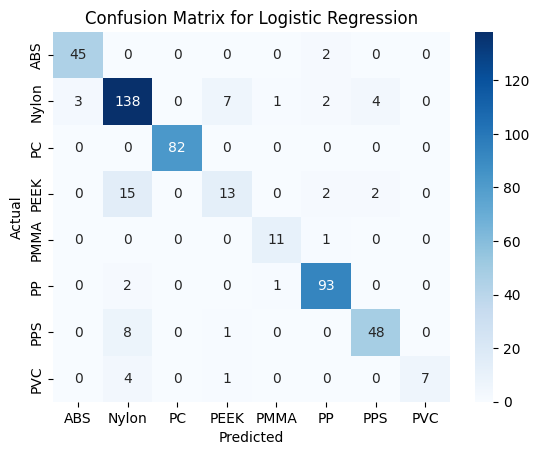

In [115]:
print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))
print(f"Training time for Logistic Regression (Grid Search): {train_time_logreg_gs:.2f} seconds")


# Visualize the results with seaborn
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure()
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### K-Nearest Neighbors


Best parameters: {'kneighborsclassifier__n_neighbors': 1}
Best cross-validation score: 0.9360559913859406
Test set score: 0.9310344827586207
Training time for KNN (Grid Search): 2.52 seconds


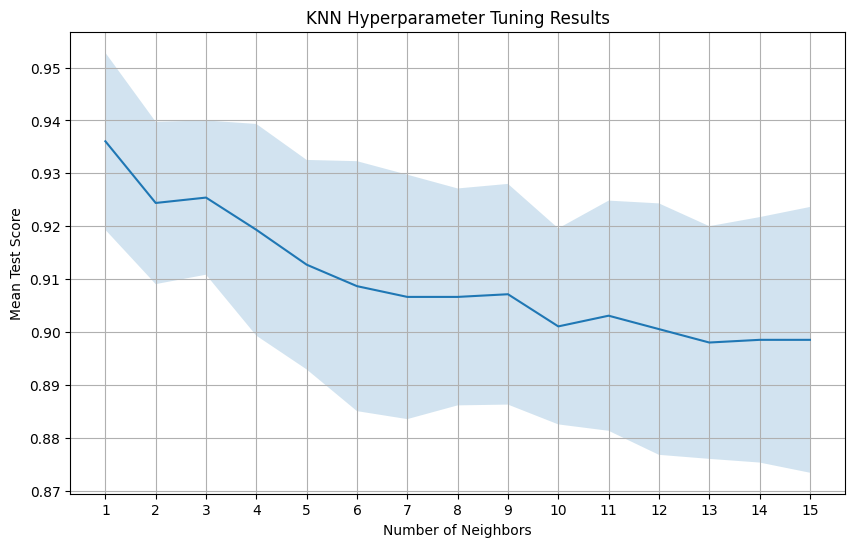

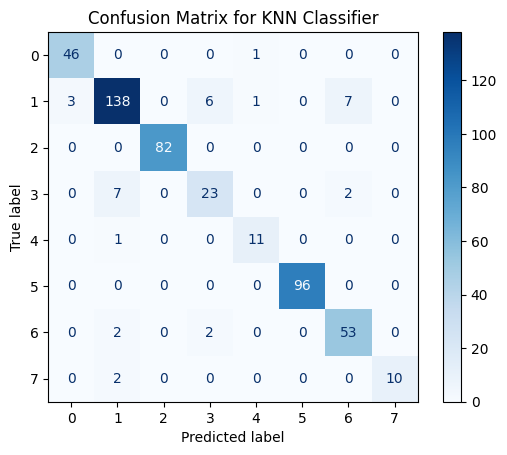

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import time


param_range = range(1, 16)
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
param_grid = [{"kneighborsclassifier__n_neighbors": param_range}]

grid_search_knn = GridSearchCV(estimator=pipe_knn, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
# Record training time
start_time_knn = time.time()
grid_search_knn.fit(X_train, y_train)
end_time_knn = time.time()
train_time_knn = end_time_knn - start_time_knn

best_knn = grid_search_knn.best_estimator_
print("Best parameters:", grid_search_knn.best_params_)
print("Best cross-validation score:", grid_search_knn.best_score_)
print("Test set score:", grid_search_knn.score(X_test, y_test))
print(f"Training time for KNN (Grid Search): {train_time_knn:.2f} seconds")




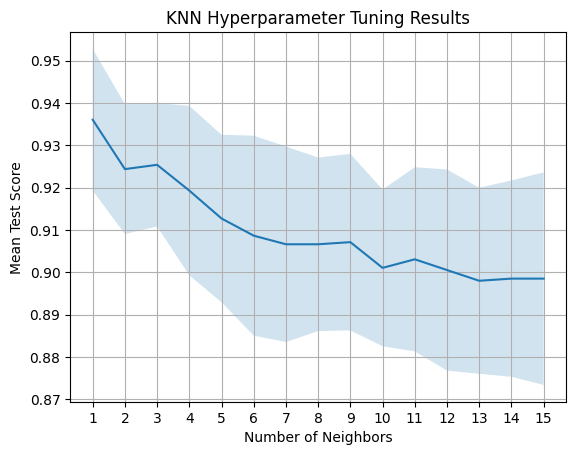

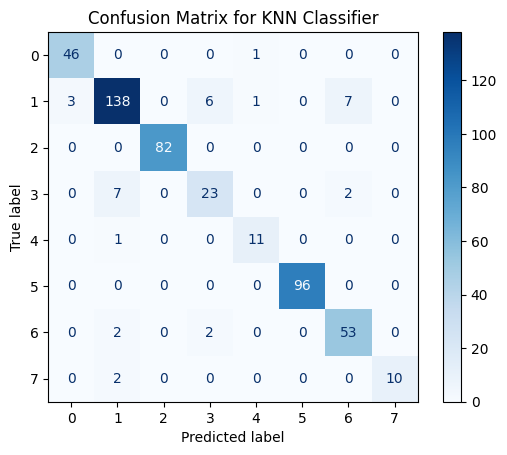

In [116]:
# Visualize the results with seaborn
results = pd.DataFrame(grid_search_knn.cv_results_)
plt.figure()
sns.lineplot(x="param_kneighborsclassifier__n_neighbors", y="mean_test_score", data=results)
plt.fill_between(
    results["param_kneighborsclassifier__n_neighbors"],
    results["mean_test_score"] - results["std_test_score"],
    results["mean_test_score"] + results["std_test_score"],
    alpha=0.2,
)
plt.title("KNN Hyperparameter Tuning Results")
plt.xlabel("Number of Neighbors")
plt.ylabel("Mean Test Score")
plt.xticks(param_range)
plt.grid()
plt.show()

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_knn = grid_search_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred_knn, labels=grid_search_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN Classifier")
plt.show()

### Random Forest


In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import time

# Pipeline (scaling not strictly needed for Random Forest, but kept for consistency)
pipe_rf = make_pipeline(
    StandardScaler(),  # Can remove if all features are numeric and well-scaled already
    RandomForestClassifier(random_state=42),
)

# Grid of hyperparameters
param_grid_rf = {
    "randomforestclassifier__n_estimators": [100, 200],
    "randomforestclassifier__max_depth": [None, 10, 20],
    "randomforestclassifier__min_samples_split": [2, 5],
    "randomforestclassifier__min_samples_leaf": [1, 2],
    "randomforestclassifier__max_features": ["sqrt", "log2", None],
}

# Grid search
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)

# Fit and record time
start_time_rf = time.time()
grid_search_rf.fit(X_train, y_train)
end_time_rf = time.time()
train_time_rf = end_time_rf - start_time_rf

best_rf = grid_search_rf.best_estimator_

# Predict with best model
y_pred_rf = grid_search_rf.predict(X_test)

print(f"Training time for Random Forest (Grid Search): {train_time_rf:.2f} seconds")

Training time for Random Forest (Grid Search): 178.01 seconds


Best parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}
Test classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       0.92      0.93      0.92       155
           2       1.00      1.00      1.00        82
           3       0.83      0.78      0.81        32
           4       0.91      0.83      0.87        12
           5       0.98      1.00      0.99        96
           6       0.96      0.95      0.96        57
           7       1.00      0.83      0.91        12

    accuracy                           0.95       493
   macro avg       0.95      0.92      0.93       493
weighted avg       0.95      0.95      0.95       493



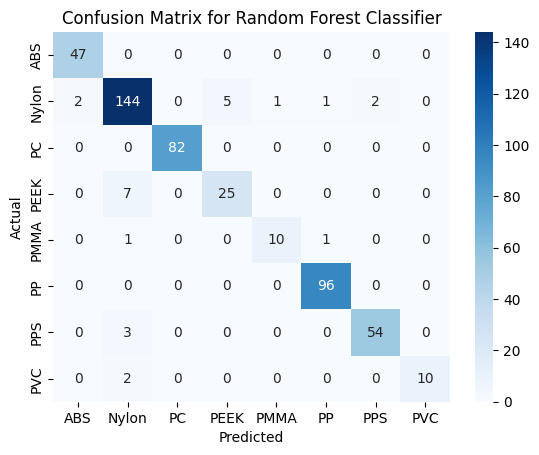

In [109]:
# Results
print("Best parameters:", grid_search_rf.best_params_)
print("Test classification report:")
print(classification_report(y_test, y_pred_rf))

# Visualize the results with seaborn
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure()
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### XGBoost


In [113]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import time

pipe_xgb = make_pipeline(
    StandardScaler(),  # Optional: XGBoost doesn't need this unless inputs are wildly scaled
    XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
)

param_dist_xgb = {
    "xgbclassifier__n_estimators": [100, 200, 300, 500],
    "xgbclassifier__max_depth": [3, 5, 7, 10],
    "xgbclassifier__learning_rate": np.linspace(0.01, 0.3, 10),
    "xgbclassifier__subsample": [0.6, 0.7, 0.8, 1.0],
    "xgbclassifier__colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "xgbclassifier__gamma": [0, 1, 3, 5],
    "xgbclassifier__reg_lambda": [0, 0.1, 1, 10],
}
random_search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=50,  # Try 50 random combos
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
)

# Fit and record time
start_time_xgb = time.time()
random_search_xgb.fit(X_train, y_train)
end_time_xgb = time.time()
train_time_xgb = end_time_xgb - start_time_xgb

best_xbg = random_search_xgb.best_estimator_

print(f"Training time for XGBoost (Randomized Search): {train_time_xgb:.2f} seconds")

Training time for XGBoost (Randomized Search): 113.64 seconds


In [ ]:
# Predict and evaluate
y_pred_xgb = random_search_xgb.predict(X_test)
print("Best parameters:", random_search_xgb.best_params_)
print("Best CV accuracy: {:.3f}".format(random_search_xgb.best_score_))
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for XGBoost Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [118]:
# Extract scores from classification reports
# Assuming y_test, y_pred_logreg, y_pred_knn, y_pred_rf, y_pred_xgb, and label_encoder are available from previous executions
logreg_report = classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_, output_dict=True)
knn_report = classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_, output_dict=True)
rf_report = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_, output_dict=True)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_, output_dict=True)

# Create a DataFrame to store the scores
scores_data = []
for model_name, report, train_time in [('Logistic Regression', logreg_report, train_time_logreg_gs),
                                        ('KNN', knn_report, train_time_knn),
                                        ('Random Forest', rf_report, train_time_rf),
                                        ('XGBoost', xgb_report, train_time_xgb)]:
    scores_data.append({
        'Model': model_name,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Accuracy': report['accuracy'],
        'Training Time (s)': train_time
    })

df_scores = pd.DataFrame(scores_data)

# Set the index to the Model name for easier styling
df_scores = df_scores.set_index('Model')

# Highlight the maximum value in each score column, and minimum for training time
styled_df = df_scores.style.highlight_max(subset=['Precision', 'Recall', 'F1-Score', 'Accuracy'], color='lightgreen') \
                     .highlight_min(subset=['Training Time (s)'], color='lightgreen')


# Display the styled table
display(styled_df)

,Precision,Recall,F1-Score,Accuracy,Training Time (s)
Model,,,,,
Logistic Regression,0.882669,0.886410,0.881526,0.886410,17.873794
KNN,0.931732,0.931034,0.930854,0.931034,2.515928
Random Forest,0.948941,0.949290,0.948755,0.949290,178.005159
XGBoost,0.969207,0.969574,0.969186,0.969574,113.638823


### Model Comparison

After compiling our results, we see that the tuned XGBoost performs the best, with high metrics across all scores and an accuracy just under 97%. K-nearest neighbors was the least computationally expensive method with a training time of less than 3 seconds.

For the absolute best accuracy, we will select XGBoost as our chosen final model. However, it is certainly worth noting that K-Nearest neighbors trains much more quickly with only a ~4% drop in accuracy.



In [ ]:

# Extract scores from classification reports
# Assuming y_test, y_pred_logreg, y_pred_knn, y_pred_rf, y_pred_xgb, and label_encoder are available from previous executions
logreg_report = classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_, output_dict=True)
knn_report = classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_, output_dict=True)
rf_report = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_, output_dict=True)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_, output_dict=True)

# Create a DataFrame to store the scores
scores_data = []
for model_name, report in [('Logistic Regression', logreg_report), ('KNN', knn_report), ('Random Forest', rf_report), ('XGBoost', xgb_report)]:
    scores_data.append({
        'Model': model_name,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Accuracy': report['accuracy']
    })

df_scores = pd.DataFrame(scores_data)

# Set the index to the Model name for easier styling
df_scores = df_scores.set_index('Model')

# Highlight the maximum value in each column
styled_df = df_scores.style.highlight_max(color='lightgreen')

# Display the styled table
display(styled_df)

,Precision,Recall,F1-Score,Accuracy
Model,,,,
Logistic Regression,0.882669,0.886410,0.881526,0.886410
KNN,0.931732,0.931034,0.930854,0.931034
Random Forest,0.948941,0.949290,0.948755,0.949290
XGBoost,0.969207,0.969574,0.969186,0.969574


## Final Model Analysis



### Actual vs. Predicted Plots

In [ ]:
yr5tttttttttt_pred_xgb_best = best_xbg.predict(X_test)
df_results = X_test.copy()
df_results["original_class"] = y_test
df_results["predicted_class"] = y_pred_xgb_best

# Inverse transform the labels
df_results["original_class"] = label_encoder.inverse_transform(df_results["original_class"])
df_results["predicted_class"] = label_encoder.inverse_transform(df_results["predicted_class"])

display(df_results.head())

,density,flexural_modulus,flexural_strength,tensile_modulus,tensile_elongation_at_break,izod_notched_impact,original_class,predicted_class
2975,0.568901,0.084202,0.503778,0.122055,-0.529852,-0.234937,Nylon,Nylon
1802,-0.420885,-0.724395,-0.504292,-0.730275,2.658160,2.238531,PC,PC
2984,-0.703681,-0.609186,-0.432287,-0.604146,-0.057554,-0.628780,Nylon,Nylon
693,3.161198,2.495057,1.103820,2.357988,-0.624311,-0.533129,PPS,PPS
1804,-0.420885,-0.724395,-0.504292,-0.716898,2.894309,2.811978,PC,PC


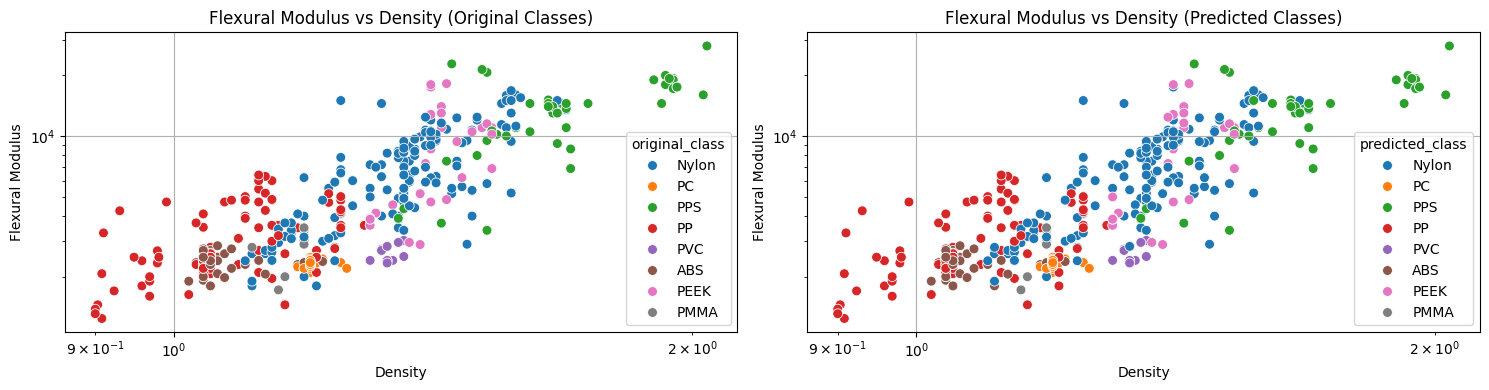

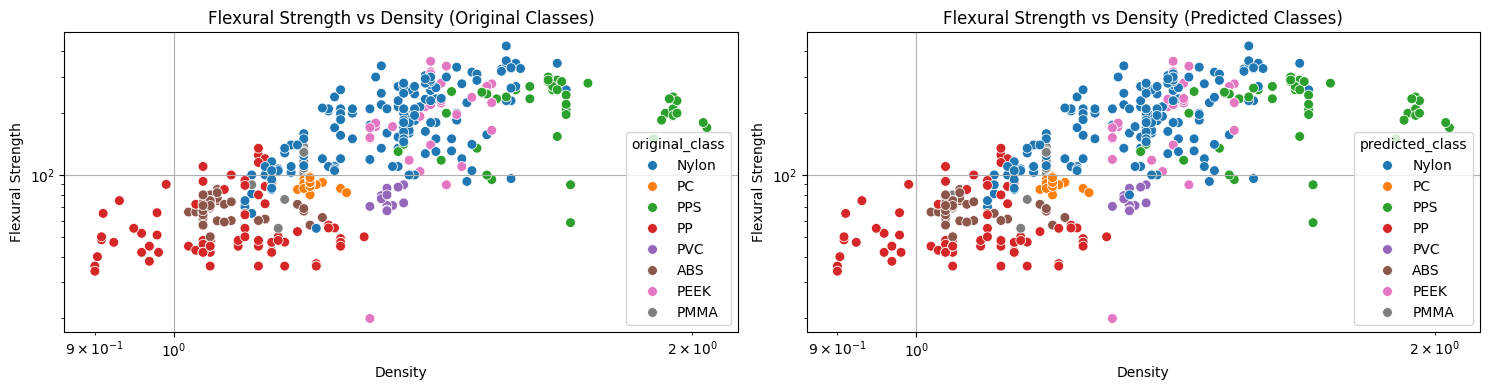

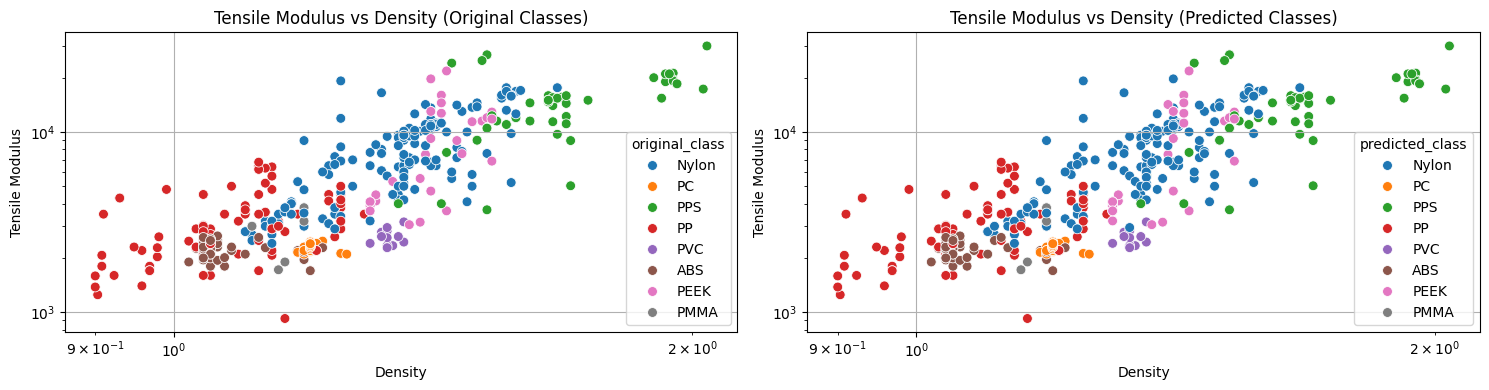

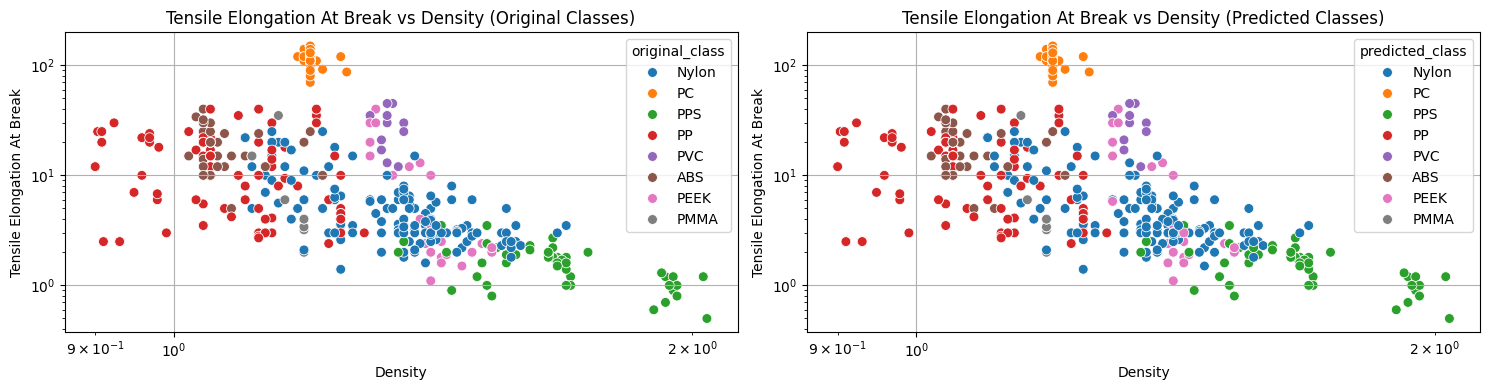

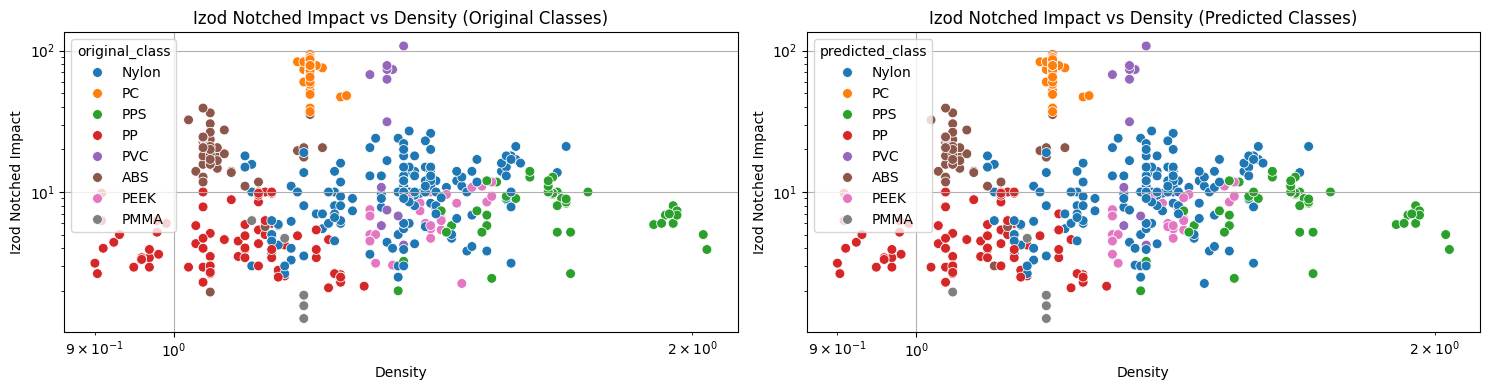

In [106]:
# Unscale the numerical features in df_results
numerical_features_to_unscale = df_results.select_dtypes(include=["float64", "int64"]).columns.tolist()
# Exclude the 'polymer_class' columns as they are not numerical features to be unscaled
numerical_features_to_unscale = [col for col in numerical_features_to_unscale if col not in ['original_class', 'predicted_class']]

# Create a temporary DataFrame to store the unscaled features
df_results_unscaled = df_results.copy()
df_results_unscaled[numerical_features_to_unscale] = scaler.inverse_transform(df_results[numerical_features_to_unscale])


features_to_plot = [feature for feature in numerical_features_to_unscale if feature != 'density']


for feature in features_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    sns.scatterplot(x="density", y=feature, hue="original_class", data=df_results_unscaled, palette='tab10', s=50, ax=axes[0])
    axes[0].set_title(f"{feature.replace('_', ' ').title()} vs Density (Original Classes)")
    axes[0].set_xlabel("Density")
    axes[0].set_ylabel(f"{feature.replace('_', ' ').title()}")
    axes[0].grid(True)
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')


    sns.scatterplot(x="density", y=feature, hue="predicted_class", data=df_results_unscaled, palette='tab10', s=50, ax=axes[1])
    axes[1].set_title(f"{feature.replace('_', ' ').title()} vs Density (Predicted Classes)")
    axes[1].set_xlabel("Density")
    axes[1].set_ylabel(f"{feature.replace('_', ' ').title()}")
    axes[1].grid(True)
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

### Feature Importance


Feature Importances from the best XGBoost model:


,Feature,Importance
4,tensile_elongation_at_break,0.281374
2,flexural_strength,0.228830
0,density,0.178268
5,izod_notched_impact,0.137893
3,tensile_modulus,0.101931
1,flexural_modulus,0.071704


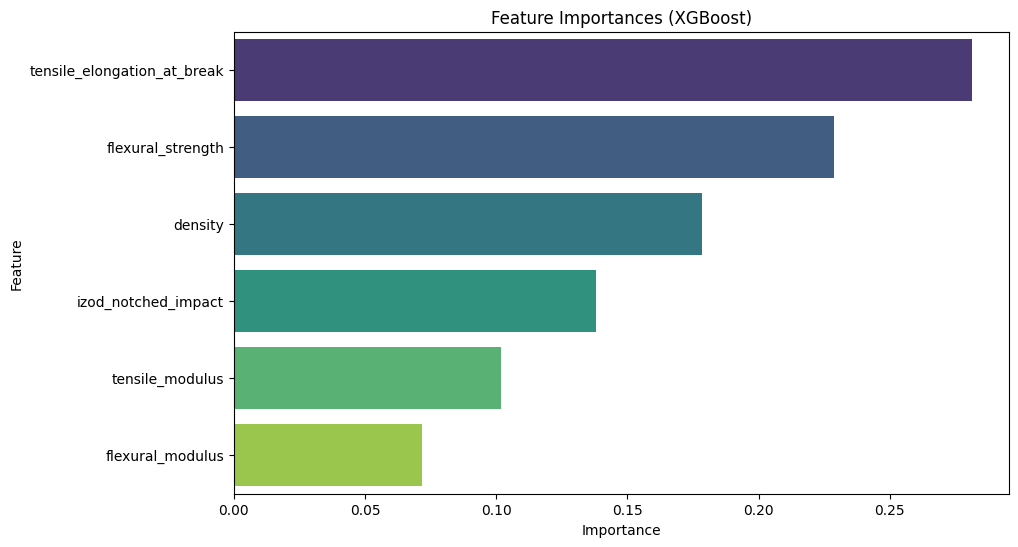

In [107]:
# Get feature importances from the best XGBoost model
feature_importances = best_xbg.named_steps['xgbclassifier'].feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances from the best XGBoost model:")
display(features_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title("Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()